<a href="https://colab.research.google.com/github/WhiteTeaDragon/SingularValues/blob/main/SingularClippingConvTT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.python.keras import regularizers
import numpy as np
import random as rn
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras.engine.input_spec import InputSpec
import six
import functools
from tensorflow.python.ops import nn, nn_ops
import keras.backend as K
from keras.callbacks import LambdaCallback
import copy
import keras

np.random.seed(1)   
rn.seed(1)   
tf.random.set_seed(1234)

### Функции

In [2]:
def full_tt(K1, K2, K3):
    """Converts a TensorTrain into a regular tensor or matrix (tf.Tensor)."""
    res = K1
    K2_reshaped = tf.reshape(K2, (K2.shape[0], -1))
    res = tf.matmul(res, K2_reshaped)
    res = tf.reshape(res, (-1, K3.shape[0]))
    res = tf.matmul(res, K3)
    res = tf.reshape(res, (K1.shape[0],) + K2.shape[1:-1] + (K3.shape[-1],))
    num_dims = len(K2.shape[1:-1])
    return tf.transpose(res, list(range(1, num_dims + 1)) + [0, num_dims + 1])

In [3]:
def Clip_OperatorNorm(conv, inp_shape, clip_to):
    conv_tr = tf.cast(tf.transpose(conv, perm=[2, 3, 0, 1]), tf.complex128)
    conv_shape = conv.get_shape().as_list()
    padding = tf.constant([[0, 0], [0, 0],
                            [0, inp_shape[0] - conv_shape[0]],
                            [0, inp_shape[1] - conv_shape[1]]])
    transform_coeff = tf.signal.fft2d(tf.pad(conv_tr, padding))
    D, U, V = tf.linalg.svd(tf.transpose(transform_coeff, perm = [2, 3, 0, 1]))
    norm = tf.reduce_max(D)
    D_clipped = tf.cast(tf.minimum(D, clip_to), tf.complex128)
    clipped_coeff = tf.matmul(U, tf.matmul(tf.linalg.diag(D_clipped),
                                            V, adjoint_b=True))
    clipped_conv_padded = tf.math.real(tf.signal.ifft2d(
        tf.transpose(clipped_coeff, perm=[2, 3, 0, 1])))
    return tf.slice(tf.transpose(clipped_conv_padded, perm=[2, 3, 0, 1]),
                    [0] * len(conv_shape), conv_shape), norm

In [4]:
class Clipping(tf.keras.callbacks.Callback):
    def __init__(self, clip_to):
        tf.keras.callbacks.Callback.__init__(self)
        self.clip_to = clip_to

    @staticmethod
    def get_new_K(K1, K2, K3):
        # (m, R) -> (m, min(m, R)) -- q: q.T @ q = I, (min(m, R), R) -- r
        q1, r1 = tf.linalg.qr(K1, full_matrices=False)
        q3, r3 = tf.linalg.qr(tf.transpose(K3), full_matrices=False)
        middle_k = full_tt(r1, K2, tf.transpose(r3))
        return q1, middle_k, tf.transpose(q3)

    def on_epoch_end(self, epochs, logs=None):
        for layer in self.model.layers:
            if layer.name[:17] == "conv_decomposed2d":
                K1, K2, K3 = self.get_new_K(layer.K1, layer.K2, layer.K3)
                K2 = tf.transpose(Clip_OperatorNorm(K2, layer.input_shape[1:3],
                                                        self.clip_to)[0],
                                  perm=[2, 0, 1, 3])
                K.set_value(layer.K1, K1)
                K.set_value(layer.K3, K3)
                K.set_value(layer.K2, K2)

### Проверка Clipping

In [5]:
def singular_values(conv):
    inp_shape = (100, 100)
    conv_tr = tf.cast(tf.transpose(conv, perm=[2, 3, 0, 1]), tf.complex128)
    conv_shape = conv.get_shape().as_list()
    padding = tf.constant([[0, 0], [0, 0],
                            [0, inp_shape[0] - conv_shape[0]],
                            [0, inp_shape[1] - conv_shape[1]]])
    transform_coeff = tf.signal.fft2d(tf.pad(conv_tr, padding))
    s = tf.linalg.svd(tf.transpose(transform_coeff, perm = [2, 3, 0, 1]),
                            compute_uv=False)
    return s

def clever_singular_values(K1, K2, K3):
    K1, K2, K3 = Clipping.get_new_K(K1, K2, K3)
    return singular_values(K2)

def simple_singular_values(K1, K2, K3):
    return singular_values(full_tt(K1, K2, K3))

def check_funcs(rank, kernel_shape, filter_shape):
    r1 = min(filter_shape[0], rank)
    r2 = min(filter_shape[1], rank)
    K1 = np.random.rand(*(filter_shape[0], r1))
    K2 = np.random.rand(*((r1,) + kernel_shape + (r2,)))
    K3 = np.random.rand(*(r2, filter_shape[1]))
    clever_wrong = clever_singular_values(K1, K2, K3)
    clever_wrong = np.array(sorted(list(np.array(clever_wrong).ravel())))
    clever_wrong = clever_wrong[np.abs(clever_wrong) > 1e-8]
    simple_right = simple_singular_values(K1, K2, K3)
    simple_right = np.array(sorted(list(np.array(simple_right).ravel())))
    simple_right = simple_right[np.abs(simple_right) > 1e-8]
    # print(len(clever_wrong), len(simple_right))
    return np.allclose(clever_wrong, simple_right)

In [6]:
check_funcs(2, (2, 2), (2, 2))

True

In [7]:
check_funcs(4, (2, 2), (3, 5))

True

In [8]:
check_funcs(4, (2, 1), (3, 5))

True

In [9]:
check_funcs(4, (2, 2), (5, 3))

True

In [10]:
check_funcs(4, (2, 1), (5, 3))

True

In [11]:
check_funcs(4, (1, 2), (3, 5))

True

In [12]:
check_funcs(2, (2, 2), (3, 5))

True

In [13]:
check_funcs(4, (7, 7), (32, 32))

True

### Свёрточный 2D слой с ТТ-разложением

In [14]:
class ConvDecomposed2D(tf.keras.layers.Conv2D):
    def __init__(self,
                 filters,
                 kernel_size,
                 decomposition_rank,
                 strides=(1, 1),
                 padding='valid',
                 data_format=None,
                 dilation_rate=(1, 1),
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(ConvDecomposed2D, self).__init__(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            dilation_rate=dilation_rate,
            groups=1,  # does not support groups!
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            **kwargs)
        self.decomposition_rank = decomposition_rank
        self.K1 = None
        self.K2 = None
        self.K3 = None
        self.bias = None
        self._convolution_op = None

    def build(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        input_channel = self._get_input_channel(input_shape)
        r1 = min(input_channel, self.decomposition_rank)
        r2 = min(self.filters, self.decomposition_rank)

        self.K1 = self.add_weight(
            name='K1',
            shape=(input_channel, r1),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            trainable=True,
            dtype=self.dtype)
        self.K2 = self.add_weight(
            name='K2',
            shape=(r1,) + self.kernel_size + (r2,),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            trainable=True,
            dtype=self.dtype)
        self.K3 = self.add_weight(
            name='K3',
            shape=(r2, self.filters),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            trainable=True,
            dtype=self.dtype)

        # the rest is copied from Conv build function
        if self.use_bias:
            self.bias = self.add_weight(
                name='bias',
                shape=(self.filters,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                trainable=True,
                dtype=self.dtype)
        else:
            self.bias = None
        channel_axis = self._get_channel_axis()
        self.input_spec = InputSpec(min_ndim=self.rank + 2,
                                    axes={channel_axis: input_channel})

        # Convert Keras formats to TF native formats.
        if self.padding == 'causal':
            tf_padding = 'VALID'  # Causal padding handled in `call`.
        elif isinstance(self.padding, six.string_types):
            tf_padding = self.padding.upper()
        else:
            tf_padding = self.padding
        tf_dilations = list(self.dilation_rate)
        tf_strides = list(self.strides)

        tf_op_name = self.__class__.__name__
        if tf_op_name == 'Conv1D':
            tf_op_name = 'conv1d'  # Backwards compat.

        self._convolution_op = functools.partial(
            nn_ops.convolution_v2,
            strides=tf_strides,
            padding=tf_padding,
            dilations=tf_dilations,
            data_format=self._tf_data_format,
            name=tf_op_name)
        self.built = True

    def call(self, inputs):
        outputs = self._convolution_op(inputs,
                                       full_tt(self.K1, self.K2, self.K3))
        if self.use_bias:
            output_rank = outputs.shape.rank
            if self.rank == 1 and self._channels_first:
                # nn.bias_add does not accept a 1D input tensor.
                bias = array_ops.reshape(self.bias, (1, self.filters, 1))
                outputs += bias
            else:
                # Handle multiple batch dimensions.
                if output_rank is not None and output_rank > 2 + self.rank:

                    def _apply_fn(o):
                        return nn.bias_add(o, self.bias,
                                           data_format=self._tf_data_format)

                    outputs = nn_ops.squeeze_batch_dims(
                        outputs, _apply_fn, inner_rank=self.rank + 1)
                else:
                    outputs = nn.bias_add(
                        outputs, self.bias, data_format=self._tf_data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs

### Проверка работоспособности слоя на наборе данных из букв (одна из наших домашек)

#### Подготовка данных

In [15]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_large.tar.gz
!tar -xvf notMNIST_large.tar.gz >> /dev/null

--2021-05-04 16:30:10--  http://yaroslavvb.com/upload/notMNIST/notMNIST_large.tar.gz
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247336696 (236M) [application/x-gzip]
Saving to: ‘notMNIST_large.tar.gz’

notMNIST_large.tar. 100%[===================>] 235.88M  70.5MB/s    in 3.6s    

2021-05-04 16:30:14 (65.9 MB/s) - ‘notMNIST_large.tar.gz’ saved [247336696/247336696]



In [16]:
DATA_DIR = 'notMNIST_large/'

In [17]:
from glob import glob
from PIL import Image
import os

for img_path in glob(f'{DATA_DIR}/**/*.png'):
  try:
    img = Image.open(img_path)
  except:
      os.remove(img_path)

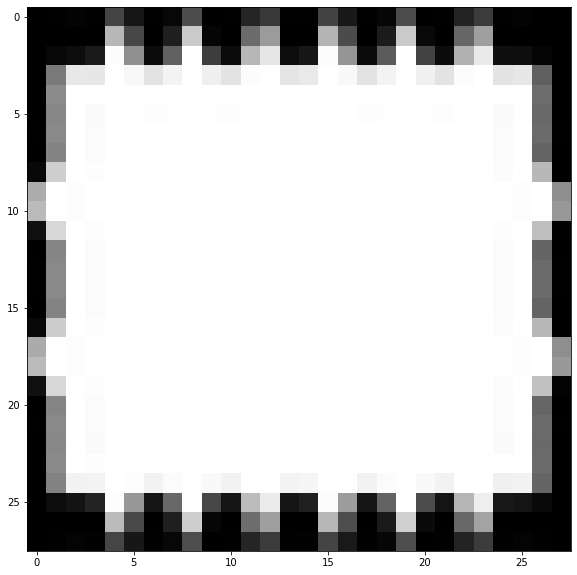

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(17,10))
letter = 'A'
img = cv2.imread(os.path.join(DATA_DIR, letter, os.listdir(f'{DATA_DIR}/{letter}/')[0]))
plt.imshow(img)

In [19]:
import os
import keras
from keras.models import Sequential
from keras.preprocessing import image
from keras.layers.core import Activation, Reshape, Dense, Flatten
from keras.layers import Conv2D, MaxPool2D, InputLayer, BatchNormalization, Dropout, GlobalAveragePooling2D, GlobalMaxPool2D
from keras.models import Model

pic_size = 28
n_classes = len(os.listdir(DATA_DIR))

def build_model(decomposition_rank):
    model = keras.Sequential([
        ConvDecomposed2D(32, 3, decomposition_rank=decomposition_rank,
                        input_shape=(pic_size, pic_size, 3),
                            data_format="channels_last", activation='relu',
                            padding='same'),
        keras.layers.MaxPooling2D(),
        ConvDecomposed2D(32, 3, decomposition_rank=decomposition_rank,
                        activation='relu', padding='same'),
        keras.layers.MaxPooling2D(),
        ConvDecomposed2D(16, 3, decomposition_rank=decomposition_rank,
                        activation='relu', padding='same'),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'])
    model.summary()
    return model

In [20]:
from keras.preprocessing.image import ImageDataGenerator

# Подсказка: train/val split удобно делать вот так https://stackoverflow.com/questions/53037510/can-flow-from-directory-get-train-and-validation-data-from-the-same-directory-in (самый залайканый ответ)

""" Data generators initialization: for train and validation sets """
generator = ImageDataGenerator(validation_split=0.1, rescale=1./255)
train_gen = generator.flow_from_directory(DATA_DIR,
                                          target_size=(pic_size, pic_size),
                                          class_mode='categorical',
                                          subset='training', seed=1)
val_gen = generator.flow_from_directory(DATA_DIR,
                                        target_size=(pic_size, pic_size),
                                        class_mode='categorical',
                                        subset='validation', seed=1)

Found 476205 images belonging to 10 classes.
Found 52909 images belonging to 10 classes.


#### decomposition_rank = 17

In [21]:
model1 = build_model(17)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_decomposed2d (ConvDecom (None, 28, 28, 32)        1044      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv_decomposed2d_1 (ConvDec (None, 14, 14, 32)        3721      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv_decomposed2d_2 (ConvDec (None, 7, 7, 16)          3264      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 144)               0

In [22]:
step_size_train = (train_gen.n // train_gen.batch_size)
step_size_valid = (val_gen.n // val_gen.batch_size)

history2 = model1.fit(train_gen, steps_per_epoch=step_size_train, epochs=2,
                    validation_data=val_gen,
                    validation_steps=step_size_valid, callbacks=[Clipping(0.5)])

Epoch 1/2
14881/14881 [==============================] - 196s 11ms/step - loss: 0.4638 - accuracy: 0.8611 - val_loss: 0.2754 - val_accuracy: 0.9175
Epoch 2/2
14881/14881 [==============================] - 157s 11ms/step - loss: 0.4092 - accuracy: 0.8698 - val_loss: 0.2394 - val_accuracy: 0.9278
